In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set_style("whitegrid")

def generate_default_plot_env():
    sns.set(font_scale=1.4, style="whitegrid")
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rc('font', family='sans-serif') 
    matplotlib.rc('font', serif='Helvetica Neue') 
    matplotlib.rc('text', usetex='false') 
    matplotlib.rcParams.update({'font.size': 22})
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rc('font', family='sans-serif') 
    plt.rc('font', serif='Helvetica Neue') 
    plt.rc('text', usetex='false') 
    plt.rcParams.update({'font.size': 22})
    
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
generate_default_plot_env()

In [4]:
grouped_df = pd.read_csv('../data/steps_diff_vs_ws_diff.csv')
more_specific_df = pd.read_csv('../data/steps_diff_vs_ws_diff_detailed.csv')
specific_locs_df = pd.read_csv('../data/fig2a_specifics.csv')

In [5]:
def classify_bin(b):
    return np.mean([float(b[1:].split(', ')[0]), float(b[:-1].split(', ')[1])])

In [6]:
grouped_df['fake_ws_diff'] = pd.to_numeric(grouped_df['ws_diff_bin'].apply(classify_bin))

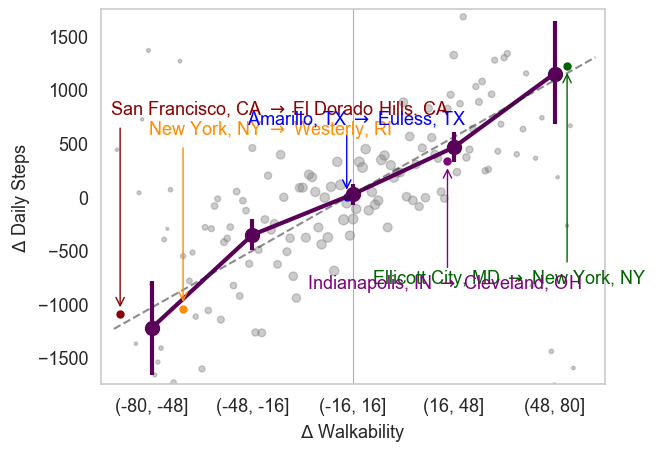

In [9]:
fig, ax = plt.subplots()

centerline_color = '#590059'
ax.plot(grouped_df['fake_ws_diff'], grouped_df['mean'], marker='o', markersize=10., linewidth=3.0,
        color=centerline_color)
ax.axvline(x=0, color='#b0b0b0', linewidth=0.8, zorder=-1)

more_specific_df_new = pd.DataFrame([more_specific_df.loc[idx] 
                                     for idx in more_specific_df.index 
                                     for _ in range(more_specific_df.loc[idx]['n_moves'])]).reset_index(drop=True)

sns.regplot(x=more_specific_df_new['ws_diff'], y=more_specific_df_new['steps_diff'], 
            scatter=False, ci=None, ax=ax, color='k', 
            line_kws={'linestyle': '--', 'linewidth': 1.5, 'color':'k', 'alpha': 0.5})

ax.errorbar(x=grouped_df['fake_ws_diff'], y=grouped_df['mean'], 
            yerr=[grouped_df['bottom_ci'], grouped_df['top_ci']], 
            linestyle="None", ecolor=centerline_color,
            elinewidth=3.0)

ax.set_xlabel('$\Delta$ Walkability')
ax.set_ylabel('$\Delta$ Daily Steps')
ax.set_ylim(-1750, 1750)
ax.set_xlim(-80, 80)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks(grouped_df['fake_ws_diff'])
ax.set_xticklabels(grouped_df['ws_diff_bin'])

highlight_df = specific_locs_df
def highlight_point(from_loc, to_loc, ax, color='k', 
                    arrow_end=None, xytext=(-20, -40), anno=True, 
                    connectionstyle='arc3'):
    
    arrow_end = (0, xytext[1]) if arrow_end is None else arrow_end
    
    vals = highlight_df[(highlight_df['from_loc'] == from_loc) & (highlight_df['to_loc'] == to_loc)][['ws_diff', 'steps_diff']]
    if anno:
        ax.annotate('',
                    xy=(vals.iloc[0, 0], vals.iloc[0, 1]), xycoords='data',
                    xytext=arrow_end, textcoords='offset pixels',
                    size=15,
                    arrowprops=dict(arrowstyle="->", 
                                    color=color,
                                    lw=1.,
                                    shrinkA=10, shrinkB=5,
                                    connectionstyle=connectionstyle),
                    color=color)
        
        ax.annotate(r"%s $\rightarrow$ %s" % (from_loc, to_loc),
                    xy=(vals.iloc[0, 0], vals.iloc[0, 1]), xycoords='data',
                    xytext=xytext, textcoords='offset pixels',
                    size=13, color=color)
    
    ax.scatter(x=[vals.iloc[0, 0]], y=[vals.iloc[0, 1]], c=color, s=25.)


highlight_point('San Francisco, CA', 'El Dorado Hills, CA', ax,
                color='darkred', xytext=(-10, 200))

highlight_point('Ellicott City, MD', 'New York, NY', ax,
                color='darkgreen', arrow_end=(0, -210), xytext=(-195, -217))

highlight_point('New York, NY', 'Westerly, RI', ax,
                color='darkorange', xytext=(-35, 175))

highlight_point('Indianapolis, IN', 'Cleveland, OH', ax,
                color='purple', arrow_end=(0, -120), xytext=(-140, -127))

highlight_point('Amarillo, TX', 'Euless, TX', ax,
                color='blue', arrow_end=(0, 75), xytext=(-100, 72))

ax.scatter(more_specific_df['ws_diff'], more_specific_df['steps_diff'], 
           s=4*np.sqrt(more_specific_df['n_moves']),
           c='grey', zorder=0, alpha=0.4);

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(13)

figure = plt.gcf() # get current figure
figure.set_size_inches(7, 5)
plt.tight_layout()

plt.savefig('../output/fig2a.pdf', dpi=300)